# Analyzing Scenario Results

Analyzing the data and plotting it.

In [1]:
import pickle
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.configs.shocks import order_tags
from src.configs.shocks import DEBT, LIQUIDITY, VOL, MU, JUMP, NEUTRAL, ADVERSE, SEVERE

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

%load_ext autoreload
%autoreload 2

In [43]:
def get_results(experiment_dir):
    """
    Get all the result objects in the result directory.
    """
    results = []
    parameter_dirs = [
        os.path.join(experiment_dir, f) for f in os.listdir(experiment_dir)
    ]
    for parameter_dir in parameter_dirs:
        if not os.path.isdir(parameter_dir):
            continue
        files = [os.path.join(parameter_dir, f) for f in os.listdir(parameter_dir)]
        for file in files:
            try:
                with open(file, "rb") as f:
                    result = pickle.load(f)
                results.append(result)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return results


def get_tags(result):
    shocks = result.metadata["template"].config["shocks"]
    tags = {
        MU: None,
        VOL: None,
        JUMP: None,
        DEBT: None,
        LIQUIDITY: None,
    }
    for shock in shocks:
        if shock["type"] == DEBT:
            tags[DEBT] = shock["tag"]
        elif shock["type"] == LIQUIDITY:
            tags[LIQUIDITY] = shock["tag"]
        elif shock["type"] == VOL:
            tags[VOL] = shock["tag"]
        elif shock["type"] == MU:
            tags[MU] = shock["tag"]
        elif shock["type"] == JUMP:
            tags[JUMP] = shock["tag"]

    for tag in tags:
        if tags[tag] is None:
            tags[tag] = NEUTRAL

    return tags


def get_active_debt_pct(result):
    active_debt_pcts = []
    for datum in result.data:
        active_debt = sum(datum.active_debt.values())
        initial_debt = sum(datum.initial_debt.values())
        active_debt_pcts.append(active_debt / initial_debt * 100)
    return active_debt_pcts


def compare(
    results,
    metrics=[
        "Bad Debt Pct",
        "Debt Liquidated Pct",
        "Net Llamma Profit Pct",
        "Soft Liquidation Loss Pct",
        "Borrower Loss Pct",
        "Worst Oracle Error Pct",
    ],
    include_lvr_metrics=False,
) -> pd.DataFrame:
    stats = []
    params = results[0].metadata["params"]
    parameter = list(params.keys())[0] if params else "No Parameter"
    for i, result in enumerate(results):
        starting_debt = (
            sum([datum.df["Total Debt"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )
        starting_crvusd_liquidity = (
            sum([datum.df["Total crvUSD Liquidity"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )

        param = result.metadata["params"]
        param_val = list(param.values())[0] if param else "No Parameter"
        if parameter in ["fee", "chainlink_limit"]:
            param_val /= 1e18

        stats_per_run = {
            "Name": result.metadata["template"].name,
            "Parameter": parameter,
            "Value": param_val,
            "Starting Debt (Mns)": starting_debt,
            "Total crvUSD Liquidity (Mns)": starting_crvusd_liquidity,
            "Starting Debt:Liquidity Ratio": starting_debt / starting_crvusd_liquidity,
        }

        tags = get_tags(result)
        stats_per_run.update(tags)

        for metric in metrics:
            stats_per_run[f"{metric} Mean"] = result.summary[f"{metric} Max"].mean()
            stats_per_run[f"{metric} Median"] = result.summary[f"{metric} Max"].median()
            stats_per_run[f"{metric} p99"] = result.summary[f"{metric} Max"].quantile(
                0.99
            )

        if include_lvr_metrics:
            result.summary["Pct of LVR Covered by Fees"] = (
                result.summary["Net Llamma Profit Pct Max"]
                / result.summary["Soft Liquidation Loss Pct Max"]
                * 100
            )

            stats_per_run["Pct of LVR Covered by Fees Mean"] = result.summary[
                "Pct of LVR Covered by Fees"
            ].mean()
            stats_per_run["Pct of LVR Covered by Fees Median"] = result.summary[
                "Pct of LVR Covered by Fees"
            ].median()
            stats_per_run["Pct of LVR Covered by Fees p01"] = result.summary[
                "Pct of LVR Covered by Fees"
            ].quantile(0.01)

            active_debt_pcts = get_active_debt_pct(result)
            stats_per_run["Active Debt Pct Mean"] = np.mean(active_debt_pcts)
            stats_per_run["Active Debt Pct Median"] = np.median(active_debt_pcts)

            stats_per_run[
                "Soft Liquidation Loss Pct of Active Debt Median"
            ] = stats_per_run["Soft Liquidation Loss Pct Median"] / (
                stats_per_run["Active Debt Pct Median"] / 100
            )
            stats_per_run[
                "Net Llamma Profit Pct of Active Debt Median"
            ] = stats_per_run["Net Llamma Profit Pct Median"] / (
                stats_per_run["Active Debt Pct Median"] / 100
            )

            stats_per_run[
                "Soft Liquidation Loss Pct of Active Debt Mean"
            ] = stats_per_run["Soft Liquidation Loss Pct Mean"] / (
                stats_per_run["Active Debt Pct Mean"] / 100
            )
            stats_per_run["Net Llamma Profit Pct of Active Debt Mean"] = stats_per_run[
                "Net Llamma Profit Pct Mean"
            ] / (stats_per_run["Active Debt Pct Mean"] / 100)

        stats.append(stats_per_run)

    df = pd.DataFrame(stats).astype(float, errors="ignore").round(5)
    df.sort_values(["Value", "Name"])
    return df


def annualize(daily_r):
    return ((1 + daily_r) ** 365 - 1) * 100


def monthalize(daily_r):
    return ((1 + daily_r) ** 30 - 1) * 100


def filter_vol(df, tag):
    ndf = df.copy()
    shock_fixes = {
        VOL: tag,
        MU: NEUTRAL,
        JUMP: NEUTRAL,
        LIQUIDITY: NEUTRAL,
        DEBT: NEUTRAL,
    }
    for col, tag in shock_fixes.items():
        ndf = ndf[ndf[col] == tag]
    ndf.sort_values("Value", inplace=True)
    return ndf

In [3]:
# results = get_results("../results/generic/")
results = get_results("../results/fees/")
# results = get_results("../results/debt_ceilings/")

In [7]:
df = compare(results)
print(df.shape)
df.head()

(18, 29)


,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
0,Baseline,fee,0.009,108.50913,47.61709,2.27879,neutral,neutral,neutral,neutral,neutral,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00603,0.00277,0.04636,0.01096,0.00376,0.12754,0.01096,0.00376,0.12754,0.12166,0.11874,0.17518
1,Severe vol,fee,0.009,108.35937,47.54636,2.27903,neutral,severe,neutral,neutral,neutral,0.07648,0.0,0.95354,1.97899,0.83560,13.40468,0.07916,0.04932,0.41012,0.06907,0.04136,0.35611,0.22456,0.11161,1.45053,0.12201,0.12076,0.17730
2,Adverse vol,fee,0.009,108.52466,47.58548,2.28063,neutral,adverse,neutral,neutral,neutral,0.00685,0.0,0.10362,0.61759,0.15515,7.75397,0.04776,0.02654,0.28162,0.03550,0.01795,0.22202,0.08381,0.03651,0.84982,0.12205,0.12035,0.17202
3,Baseline,fee,0.006,108.34285,47.57134,2.27748,neutral,neutral,neutral,neutral,neutral,0.00000,0.0,0.00000,0.00119,0.00000,0.00133,0.00438,0.00218,0.03506,0.01192,0.00460,0.12745,0.01201,0.00460,0.12745,0.12225,0.11999,0.17652
4,Severe vol,fee,0.006,108.23383,47.58692,2.27445,neutral,severe,neutral,neutral,neutral,0.05988,0.0,1.01500,2.02380,0.91071,15.02213,0.06174,0.03623,0.30377,0.07907,0.04527,0.43386,0.23811,0.12407,1.38857,0.13000,0.12127,0.18111


# Bad Debt vs Debt

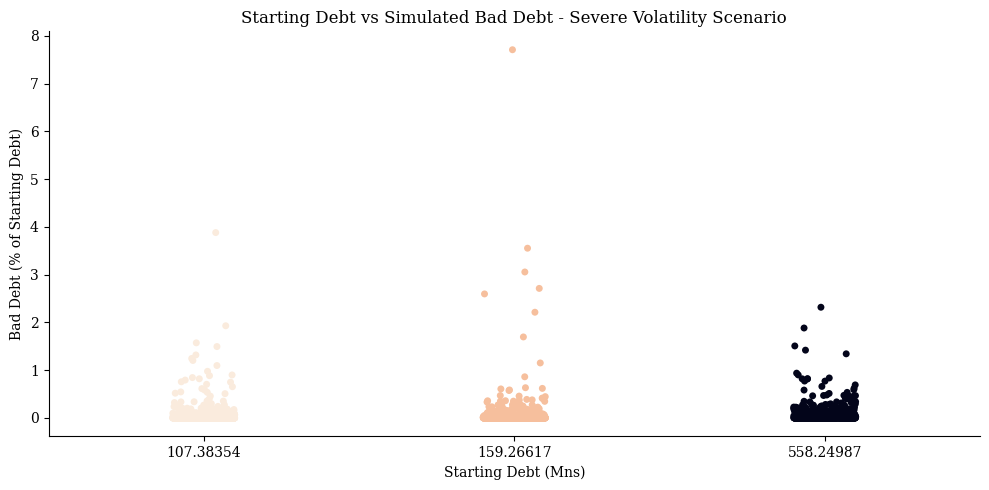

In [5]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    LIQUIDITY: NEUTRAL,
    # DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]
ndf.sort_values(["Starting Debt (Mns)"], inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf["Starting Debt (Mns)"]

# Swarm
bad_debts = []
for r, starting_debt in zip(nresults, labels):
    for i, row in r.summary.iterrows():
        bad_debts.append(
            {
                "Starting Debt (Mns)": starting_debt,
                "Bad Debt Pct": row["Bad Debt Pct Max"],
            }
        )
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=bad_debts,
    x="Starting Debt (Mns)",
    y="Bad Debt Pct",
    hue="Starting Debt (Mns)",
    legend=False,
    palette="rocket_r",
)
plt.xlabel("Starting Debt (Mns)")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Starting Debt vs Simulated Bad Debt - Severe Volatility Scenario")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_starting_debt.png", dpi=300)
plt.show()

In [6]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.00000,0.88483,2.50121,1.14014,16.54635,0.06997,0.04526,0.33021,0.09155,0.05676,0.41212,0.29135,0.16042,1.95163,0.12352,0.12066,0.17375
2,Severe vol and adverse growth,No Parameter,No Parameter,159.26617,70.90872,2.24607,neutral,severe,neutral,adverse,neutral,0.05332,0.00000,0.61871,2.50344,1.36081,13.80804,0.07173,0.04954,0.30738,0.09373,0.06600,0.39390,0.28810,0.17917,1.51941,0.15365,0.14808,0.19225
6,Severe vol and severe growth,No Parameter,No Parameter,558.24987,247.28053,2.25756,neutral,severe,neutral,severe,neutral,0.05920,0.01164,0.81577,2.69823,2.24708,8.69898,0.07631,0.06247,0.24725,0.09622,0.07938,0.29344,0.30873,0.26126,0.93215,0.12699,0.12484,0.18297


In [7]:
latex_table = (
    ndf[
        [
            "Starting Debt (Mns)",
            "Bad Debt Pct Median",
            "Bad Debt Pct Mean",
            "Bad Debt Pct p99",
        ]
    ]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{rrrr}
\toprule
Starting Debt (Mns) & Bad Debt Pct Median & Bad Debt Pct Mean & Bad Debt Pct p99 \\
\midrule
107.38 & 0.00 & 0.04 & 0.88 \\
159.27 & 0.00 & 0.05 & 0.62 \\
558.25 & 0.01 & 0.06 & 0.82 \\
\bottomrule
\end{tabular}



# LVR and Fees

How does this change as we vary fees?

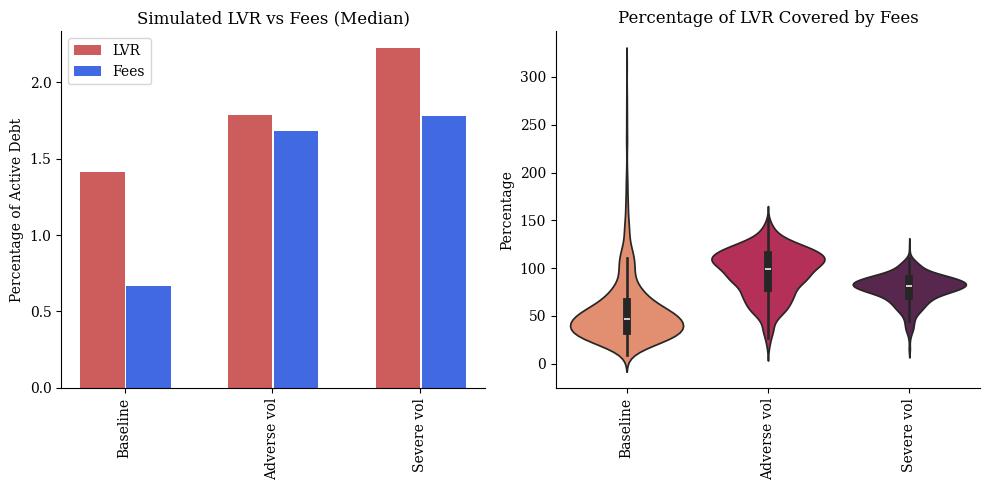

In [11]:
df = compare(results, include_lvr_metrics=True)

ndf = df.copy()
shock_fixes = {
    # VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    LIQUIDITY: NEUTRAL,
    DEBT: NEUTRAL,
    "Value": 0.006,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]
order_tags(ndf, VOL)

labels = ndf["Name"]
width = 0.3
ind = np.arange(len(ndf))

f, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ax.bar(
    ind,
    ndf["Soft Liquidation Loss Pct of Active Debt Median"],
    width=width,
    color="indianred",
    label="LVR",
)
ax.bar(
    ind + width + 0.01,
    ndf["Net Llamma Profit Pct of Active Debt Median"],
    width=width,
    color="royalblue",
    label="Fees",
)
ax.set_title("Simulated LVR vs Fees (Median)")
ax.set_ylabel("Percentage of Active Debt")
ax.tick_params(axis="x", rotation=90)
ax.set_xticks(ind + width / 2, labels)
ax.legend()

ax = axs[1]

idxs = ndf.index
nresults = [results[i] for i in idxs]
pcts = [nresult.summary["Pct of LVR Covered by Fees"].tolist() for nresult in nresults]

sns.violinplot(data=pcts, palette="rocket_r", inner="box")
ax.set_title("Percentage of LVR Covered by Fees")
ax.set_ylabel("Percentage")
ax.set_xticks(range(len(labels)), labels)
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.savefig("../figs/results/fees_lvr_pct.png", dpi=300)
plt.show()

In [12]:
latex_table = (
    ndf[[VOL, "Active Debt Pct Mean", "Active Debt Pct Median"]]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{lrr}
\toprule
vol & Active Debt Pct Mean & Active Debt Pct Median \\
\midrule
neutral & 0.66 & 0.33 \\
adverse & 2.16 & 1.25 \\
severe & 3.53 & 2.04 \\
\bottomrule
\end{tabular}



In [13]:
latex_table = (
    ndf[
        [
            VOL,
            "Soft Liquidation Loss Pct of Active Debt Median",
            "Soft Liquidation Loss Pct of Active Debt Mean",
            "Net Llamma Profit Pct of Active Debt Median",
            "Net Llamma Profit Pct of Active Debt Mean",
        ]
    ]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
vol & Soft Liquidation Loss Pct of Active Debt Median & Soft Liquidation Loss Pct of Active Debt Mean & Net Llamma Profit Pct of Active Debt Median & Net Llamma Profit Pct of Active Debt Mean \\
\midrule
neutral & 1.41 & 1.80 & 0.67 & 0.66 \\
adverse & 1.78 & 1.90 & 1.68 & 1.76 \\
severe & 2.22 & 2.24 & 1.78 & 1.75 \\
\bottomrule
\end{tabular}



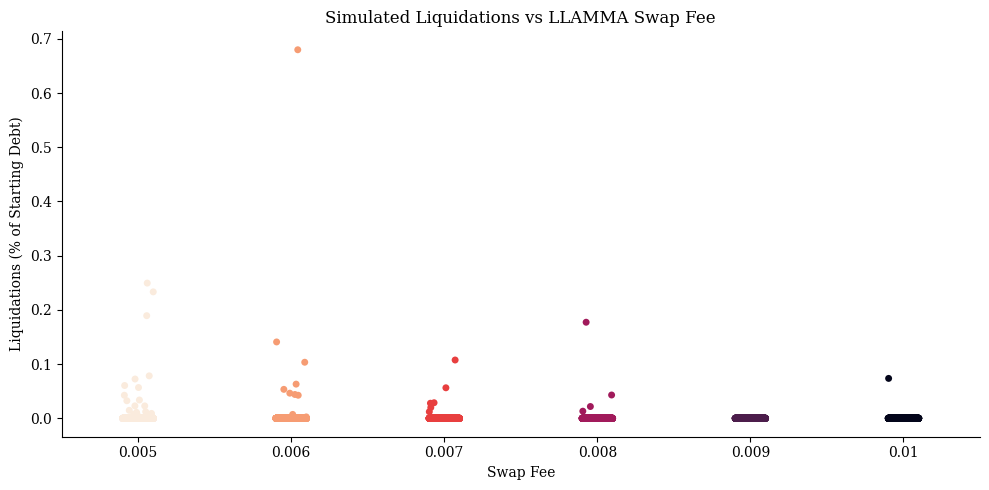

In [44]:
### Zoom in
ndf = filter_vol(df, NEUTRAL)
ndf.sort_values("Value", inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf["Value"]

bad_debts = []
for r, label in zip(nresults, labels):
    for i, row in r.summary.iterrows():
        bad_debts.append(
            {"Fee": label, "Debt Liquidated Pct": row["Debt Liquidated Pct Max"]}
        )
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=bad_debts,
    x="Fee",
    y="Debt Liquidated Pct",
    hue="Fee",
    legend=False,
    palette="rocket_r",
)
plt.xlabel("Swap Fee")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Liquidations (% of Starting Debt)")
plt.title("Simulated Liquidations vs LLAMMA Swap Fee")
plt.tight_layout()
plt.savefig("../figs/results/debt_liquidated_vs_fee_baseline.png", dpi=300)
plt.show()

In [41]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01,Active Debt Pct Mean,Active Debt Pct Median,Soft Liquidation Loss Pct of Active Debt Median,Net Llamma Profit Pct of Active Debt Median,Soft Liquidation Loss Pct of Active Debt Mean,Net Llamma Profit Pct of Active Debt Mean
12,Baseline,fee,0.005,108.54362,47.54066,2.28317,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00117,0.0,0.02302,0.00400,0.00197,0.02985,0.01235,0.00467,0.13081,0.01243,0.00470,0.13081,0.12157,0.11998,0.17762,49.24719,39.91824,14.10643,0.69244,0.34024,1.37353,0.57771,1.78374,0.57775
3,Baseline,fee,0.006,108.34285,47.57134,2.27748,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00119,0.0,0.00133,0.00438,0.00218,0.03506,0.01192,0.00460,0.12745,0.01201,0.00460,0.12745,0.12225,0.11999,0.17652,55.56621,46.38445,15.97155,0.66129,0.32613,1.41089,0.66912,1.80222,0.66282
9,Baseline,fee,0.007,108.32919,47.58450,2.27656,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00025,0.0,0.00000,0.00526,0.00241,0.03955,0.01260,0.00405,0.12766,0.01262,0.00405,0.12766,0.12238,0.12084,0.17697,66.15110,53.59375,15.83771,0.69966,0.32400,1.24899,0.74352,1.80148,0.75117
6,Baseline,fee,0.008,108.43053,47.55071,2.28031,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00025,0.0,0.00000,0.00537,0.00255,0.03509,0.01121,0.00402,0.12406,0.01123,0.00403,0.12406,0.12235,0.11999,0.18117,74.51466,59.02460,20.61063,0.65209,0.30480,1.31981,0.83680,1.71928,0.82425
0,Baseline,fee,0.009,108.50913,47.61709,2.27879,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00603,0.00277,0.04636,0.01096,0.00376,0.12754,0.01096,0.00376,0.12754,0.12166,0.11874,0.17518,84.63932,67.34071,24.81553,0.66320,0.31745,1.18313,0.87407,1.65200,0.90961
15,Baseline,fee,0.010,108.31790,47.53499,2.27870,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00007,0.0,0.00000,0.00616,0.00311,0.03989,0.00968,0.00355,0.10354,0.00968,0.00355,0.10354,0.12133,0.11972,0.17561,96.40651,76.47534,26.72283,0.63002,0.32059,1.10888,0.96871,1.53584,0.97793


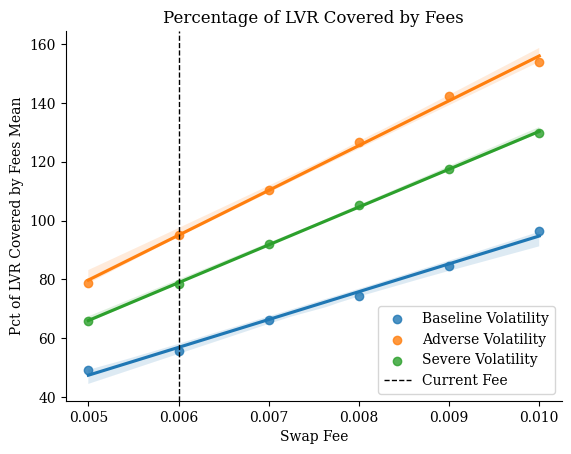

In [35]:
ndf = filter_vol(df, NEUTRAL)
sns.regplot(
    data=ndf[["Value", "Pct of LVR Covered by Fees Mean"]],
    x="Value",
    y="Pct of LVR Covered by Fees Mean",
    order=1,
    label="Baseline Volatility",
)
ndf = filter_vol(df, ADVERSE)
sns.regplot(
    data=ndf[["Value", "Pct of LVR Covered by Fees Mean"]],
    x="Value",
    y="Pct of LVR Covered by Fees Mean",
    order=1,
    label="Adverse Volatility",
)
ndf = filter_vol(df, SEVERE)
sns.regplot(
    data=ndf[["Value", "Pct of LVR Covered by Fees Mean"]],
    x="Value",
    y="Pct of LVR Covered by Fees Mean",
    order=1,
    label="Severe Volatility",
)
plt.axvline(0.006, linestyle="--", color="black", label="Current Fee", lw=1)
plt.title("Percentage of LVR Covered by Fees")
plt.xlabel("Swap Fee")
plt.legend()
plt.savefig("../figs/results/fees_lvr_pct_reg.png", dpi=300)
plt.show()

# Bad Debt vs Volatility

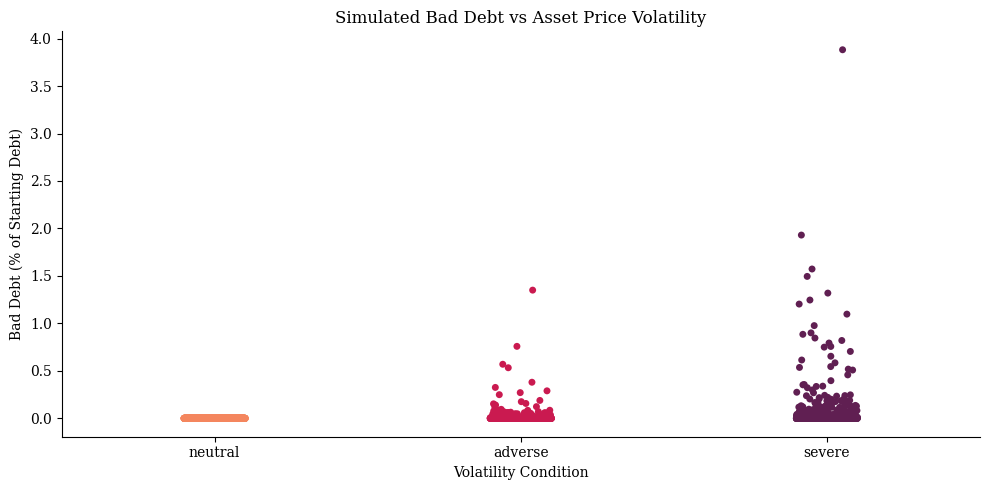

In [11]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    # VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    LIQUIDITY: NEUTRAL,
    DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]

order_tags(ndf, VOL)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf[VOL]

bad_debts = []
for r, vol in zip(nresults, labels):
    for i, row in r.summary.iterrows():
        bad_debts.append({"Volatility": vol, "Bad Debt Pct": row["Bad Debt Pct Max"]})
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=bad_debts,
    x="Volatility",
    y="Bad Debt Pct",
    hue="Volatility",
    legend=False,
    palette="rocket_r",
)
plt.xlabel("Volatility Condition")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Simulated Bad Debt vs Asset Price Volatility")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_vol.png", dpi=300)
plt.show()

In [12]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01,Active Debt Pct Mean,Active Debt Pct Median
4,Baseline,No Parameter,No Parameter,107.38833,47.73094,2.24987,neutral,neutral,neutral,neutral,neutral,0.00000,0.0,0.00000,0.00004,0.00000,0.00000,0.00596,0.00298,0.04153,0.01565,0.00579,0.15176,0.01565,0.00579,0.15176,0.12405,0.12242,0.18206,58.67950,47.03965,17.34700,0.87587,0.44487
12,Adverse vol,No Parameter,No Parameter,107.22853,47.75787,2.24525,neutral,adverse,neutral,neutral,neutral,0.00813,0.0,0.17518,0.80491,0.23809,9.63255,0.04376,0.02410,0.24298,0.04670,0.02507,0.27766,0.11036,0.05147,1.05094,0.12220,0.12007,0.17600,96.42132,101.43366,32.38344,2.48300,1.36795
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.0,0.88483,2.50121,1.14014,16.54635,0.06997,0.04526,0.33021,0.09155,0.05676,0.41212,0.29135,0.16042,1.95163,0.12352,0.12066,0.17375,77.23069,80.26728,28.33004,3.92226,2.47483


In [13]:
latex_table = (
    ndf[[VOL, "Bad Debt Pct Median", "Bad Debt Pct Mean", "Bad Debt Pct p99"]]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{lrrr}
\toprule
vol & Bad Debt Pct Median & Bad Debt Pct Mean & Bad Debt Pct p99 \\
\midrule
neutral & 0.00 & 0.00 & 0.00 \\
adverse & 0.00 & 0.01 & 0.18 \\
severe & 0.00 & 0.04 & 0.88 \\
\bottomrule
\end{tabular}



# Bad Debt vs crvUSD Liquidity

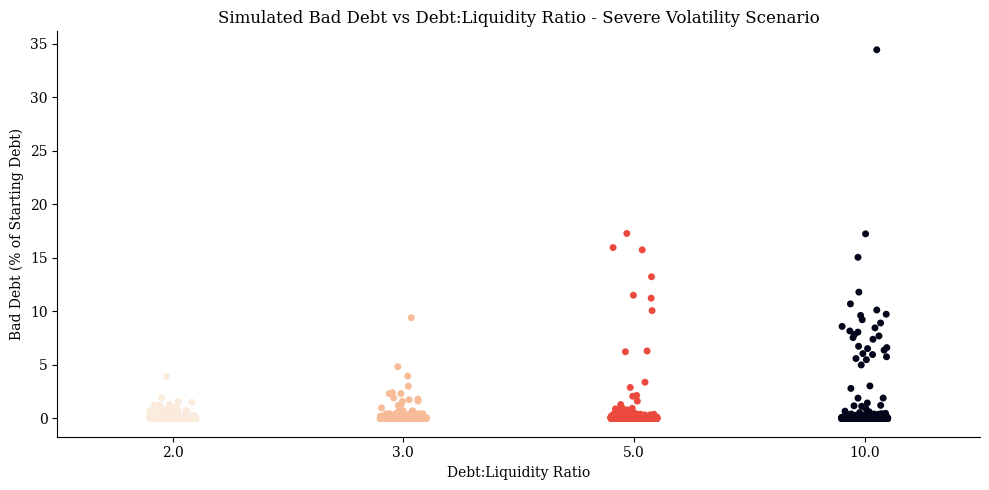

In [19]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    # LIQUIDITY: ADVERSE,
    DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]

ndf.sort_values(["Starting Debt:Liquidity Ratio"], inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = round(ndf["Starting Debt:Liquidity Ratio"])

bad_debts = []
for r, ratio in zip(nresults, labels):
    for _, row in r.summary.iterrows():
        bad_debts.append(
            {
                "Starting Debt:Liquidity Ratio": ratio,
                "Bad Debt Pct": row["Bad Debt Pct Max"],
            }
        )
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=bad_debts,
    x="Starting Debt:Liquidity Ratio",
    y="Bad Debt Pct",
    hue="Starting Debt:Liquidity Ratio",
    legend=False,
    palette="rocket_r",
)
plt.xlabel("Debt:Liquidity Ratio")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Simulated Bad Debt vs Debt:Liquidity Ratio - Severe Volatility Scenario")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_ratio.png", dpi=300)
plt.show()

In [20]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01,Active Debt Pct Mean,Active Debt Pct Median
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.0,0.88483,2.50121,1.14014,16.54635,0.06997,0.04526,0.33021,0.09155,0.05676,0.41212,0.29135,0.16042,1.95163,0.12352,0.12066,0.17375,77.23069,80.26728,28.33004,3.92226,2.47483
13,Severe vol and adverse crvUSD liquidity,No Parameter,No Parameter,108.12554,31.84887,3.39496,neutral,severe,neutral,neutral,adverse,0.06404,0.0,1.61561,2.19796,1.01120,15.15261,0.06433,0.04038,0.31092,0.08655,0.04975,0.38472,0.25783,0.13508,1.47409,0.13486,0.12111,0.18048,78.43351,81.22241,27.88334,3.76971,2.22740
5,Severe vol and severe crvUSD liquidity,No Parameter,No Parameter,108.30157,21.99535,4.92384,neutral,severe,neutral,neutral,severe,0.14948,0.0,2.88584,2.20355,0.94692,15.62809,0.06175,0.03623,0.33037,0.08335,0.04559,0.42274,0.25041,0.13460,1.62002,0.12585,0.12257,0.18716,77.72694,80.02205,33.47438,3.52117,2.01505
7,Severe vol and very severe crvUSD liquidity,No Parameter,No Parameter,108.45865,10.60554,10.22660,neutral,severe,neutral,neutral,very severe,0.29797,0.0,8.59297,2.07354,0.92161,14.19082,0.05760,0.03451,0.31654,0.07875,0.04428,0.45066,0.23366,0.12103,1.64195,0.15029,0.12127,0.45821,76.87366,79.76182,30.88185,3.33413,1.94451


In [21]:
latex_table = (
    ndf[
        [
            "Starting Debt:Liquidity Ratio",
            "Bad Debt Pct Median",
            "Bad Debt Pct Mean",
            "Bad Debt Pct p99",
        ]
    ]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{rrrr}
\toprule
Starting Debt:Liquidity Ratio & Bad Debt Pct Median & Bad Debt Pct Mean & Bad Debt Pct p99 \\
\midrule
2.25 & 0.00 & 0.04 & 0.88 \\
3.39 & 0.00 & 0.06 & 1.62 \\
4.92 & 0.00 & 0.15 & 2.89 \\
10.23 & 0.00 & 0.30 & 8.59 \\
\bottomrule
\end{tabular}



# Flash Crashes

In [160]:
### Zoom in
ndf = df.copy()
ndf = ndf[ndf[JUMP] != NEUTRAL]
ndf = ndf[ndf[DEBT] == NEUTRAL]
ndf = ndf[ndf[LIQUIDITY] == NEUTRAL]
ndf = ndf[ndf["Name"] != "Adverse depeg"]

order_tags(ndf, JUMP)

ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
13,Adverse flash crash,No Parameter,No Parameter,106.80430,47.64847,2.24151,neutral,neutral,adverse,neutral,neutral,0.94916,0.40788,8.83449,1.05871,0.25683,10.73814,0.01878,0.01395,0.07948,0.12881,0.07407,0.81642,0.18330,0.08791,1.35446,0.12398,0.12068,0.18041
14,Severe flash crash,No Parameter,No Parameter,107.00019,47.70969,2.24274,neutral,neutral,severe,neutral,neutral,5.00596,2.95151,21.84575,1.75648,0.86401,10.58558,0.04303,0.03482,0.13493,0.76639,0.49136,3.46719,0.85456,0.59458,3.61079,0.12577,0.11885,0.21222


In [149]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    # VOL: SEVERE,
    # MU: NEUTRAL,
    JUMP: SEVERE,
    # LIQUIDITY: NEUTRAL,
    # DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]

order_tags(ndf, VOL)

ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
14,Severe flash crash,No Parameter,No Parameter,107.00019,47.70969,2.24274,neutral,neutral,severe,neutral,neutral,5.00596,2.95151,21.84575,1.75648,0.86401,10.58558,0.04303,0.03482,0.13493,0.76639,0.49136,3.46719,0.85456,0.59458,3.61079,0.12577,0.11885,0.21222


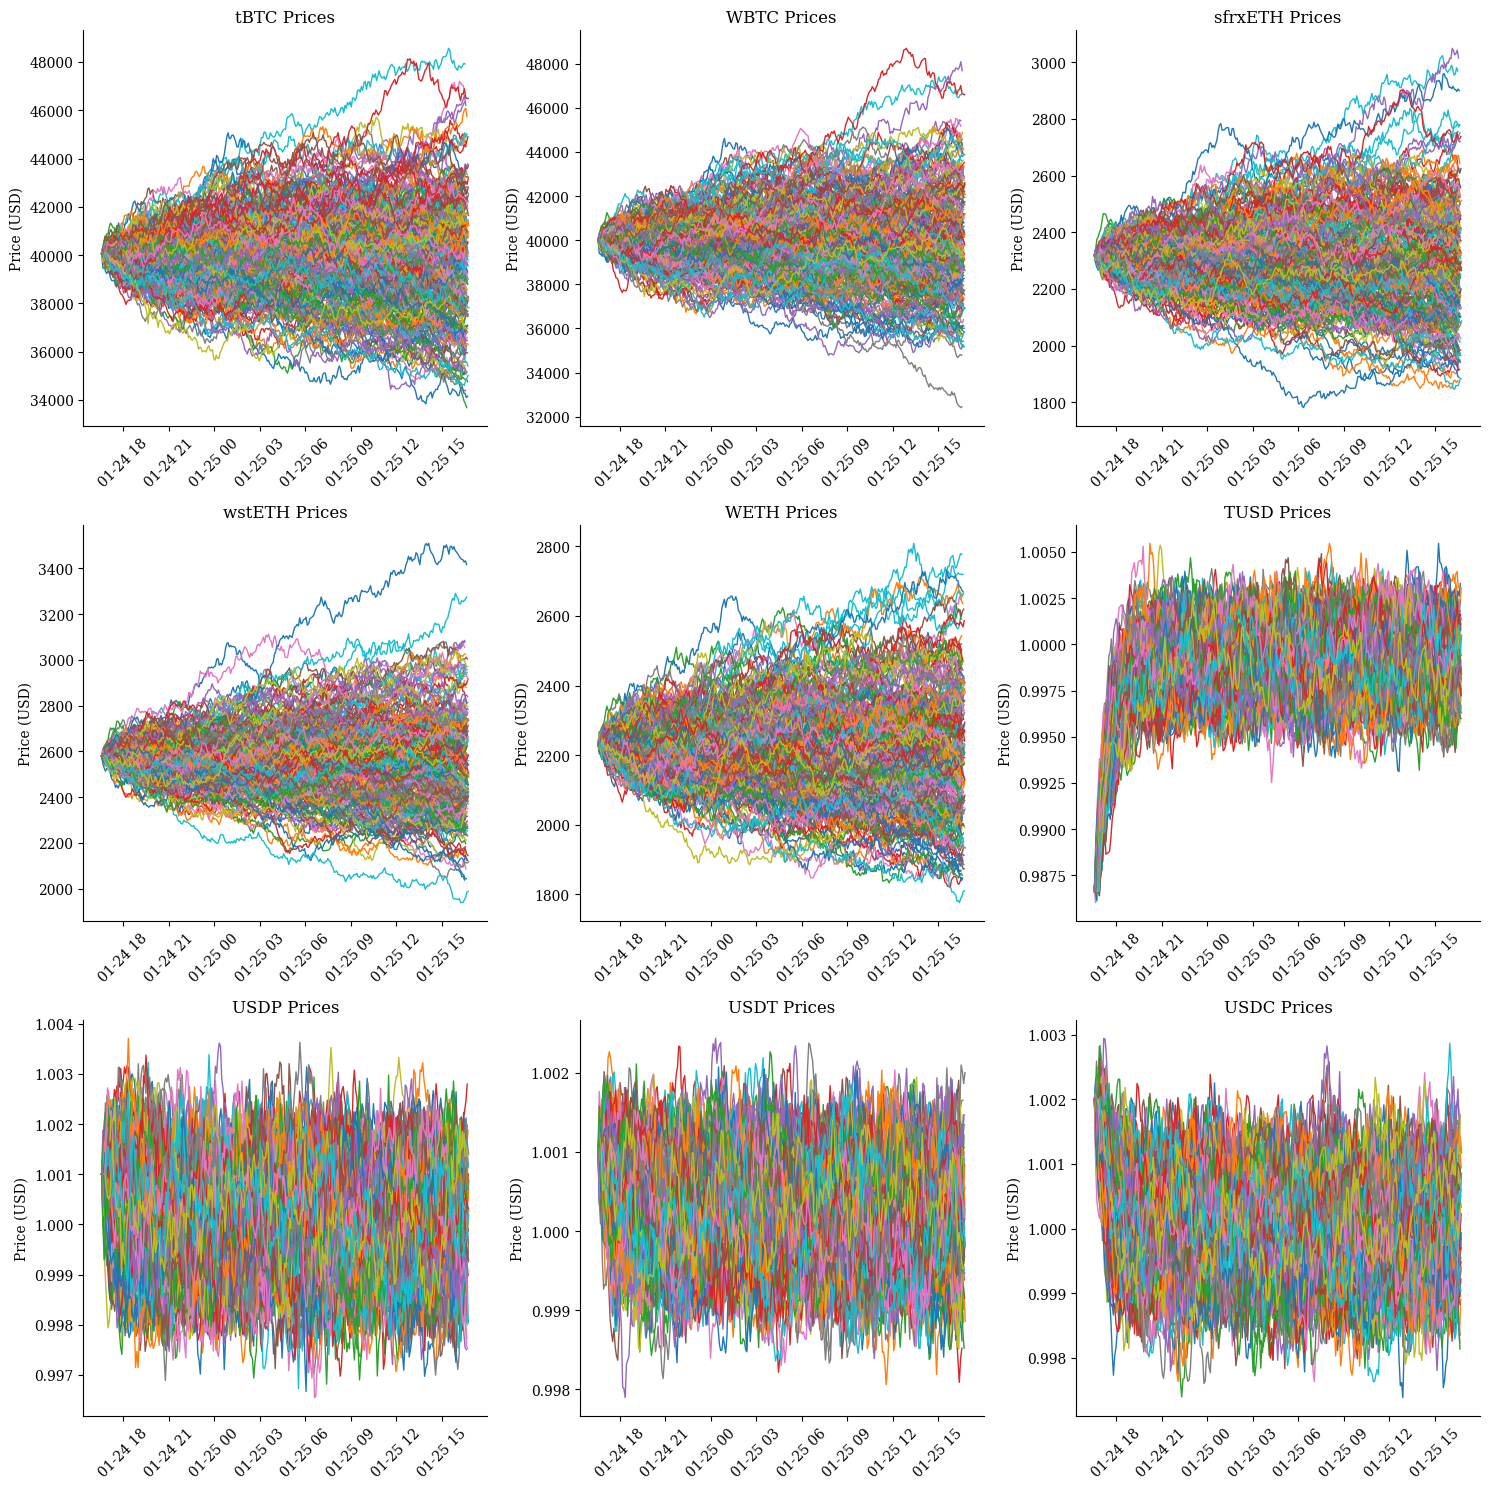

In [177]:
from src.plotting import plot_prices

result = results[15]
axs = plot_prices(result.data[0].pricepaths.prices)
for datum in result.data[1:]:
    plot_prices(datum.pricepaths.prices, axs=axs)
plt.tight_layout()
plt.savefig("../figs/results/pricepaths.png", dpi=300)
plt.show()

# Chainlink Limits

In [47]:
chainlink_results = get_results("../results/chainlink_limits")

In [48]:
df = compare(chainlink_results, include_lvr_metrics=True)
df.sort_values(["Value"], inplace=True)
df

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01,Active Debt Pct Mean,Active Debt Pct Median,Soft Liquidation Loss Pct of Active Debt Median,Net Llamma Profit Pct of Active Debt Median,Soft Liquidation Loss Pct of Active Debt Mean,Net Llamma Profit Pct of Active Debt Mean
0,Adverse depeg,chainlink_limit,0.015,108.40944,47.51989,2.28135,neutral,neutral,adverse,neutral,neutral,0.01302,0.00000,0.20842,0.03850,0.00000,1.27770,0.03123,0.02336,0.12195,0.01525,0.00493,0.14576,0.01717,0.00504,0.18709,1.49960,1.5000,1.5,1706.49932,363.12545,30.45336,2.35579,1.72066,0.28671,1.35749,0.64743,1.32548
3,Adverse depeg,chainlink_limit,0.050,108.36533,47.59929,2.27662,neutral,neutral,adverse,neutral,neutral,0.12243,0.01403,1.36185,0.83919,0.20332,10.53495,0.02309,0.01673,0.10251,0.04052,0.00928,0.51377,0.10554,0.01490,1.23920,4.88019,5.0000,5.0,inf,182.64705,9.68047,1.88002,1.30616,0.71071,1.28082,2.15545,1.22842
2,Adverse depeg,chainlink_limit,0.100,108.30081,47.57076,2.27663,neutral,neutral,adverse,neutral,neutral,0.07987,0.00000,1.26618,1.15734,0.40417,10.84271,0.01782,0.01257,0.08310,0.12355,0.05228,0.97586,0.20538,0.08112,2.17034,9.17631,10.0000,10.0,153.64257,15.65753,4.50937,1.71711,1.27294,4.10689,0.98760,7.19498,1.03755
1,Adverse depeg,chainlink_limit,0.150,108.33511,47.52854,2.27937,neutral,neutral,adverse,neutral,neutral,0.24132,0.00000,5.93745,1.17006,0.40109,11.92478,0.01952,0.01263,0.09502,0.17319,0.06105,1.69398,0.25038,0.09375,2.44265,11.63460,12.6617,15.0,192.91131,14.47999,3.07063,1.83959,1.29944,4.69832,0.97208,9.41473,1.06110


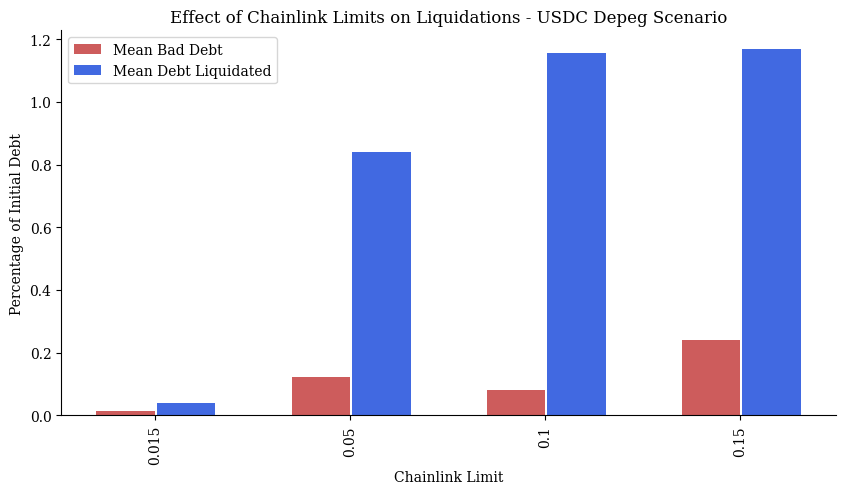

In [49]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

labels = df["Value"]
ind = np.arange(len(df))
width = 0.3

ax.bar(
    ind,
    df["Bad Debt Pct Mean"],
    width=width,
    color="indianred",
    label="Mean Bad Debt",
)
ax.bar(
    ind + width + 0.01,
    df["Debt Liquidated Pct Mean"],
    width=width,
    color="royalblue",
    label="Mean Debt Liquidated",
)
ax.set_title("Effect of Chainlink Limits on Liquidations - USDC Depeg Scenario")
ax.set_ylabel("Percentage of Initial Debt")
ax.set_xlabel("Chainlink Limit")
ax.tick_params(axis="x", rotation=90)
ax.set_xticks(ind + width / 2, labels)
ax.legend()
plt.savefig("../figs/results/chainlink_limits.png", dpi=300)
plt.show()

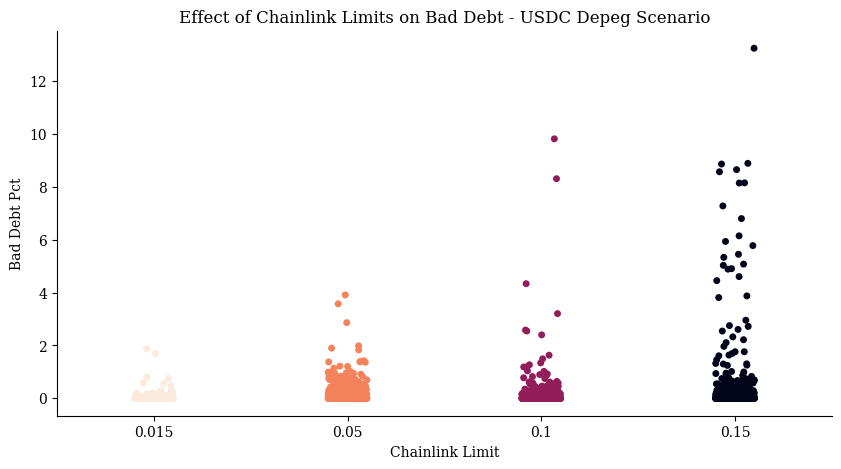

In [50]:
bad_debts = []
for r in chainlink_results:
    limit = r.metadata["params"]["chainlink_limit"] / 1e18
    for _, row in r.summary.iterrows():
        bad_debts.append(
            {"Chainlink Limit": limit, "Bad Debt Pct": row["Bad Debt Pct Max"]}
        )
bad_debts = pd.DataFrame(bad_debts)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.stripplot(
    data=bad_debts,
    x="Chainlink Limit",
    y="Bad Debt Pct",
    hue="Chainlink Limit",
    legend=False,
    palette="rocket_r",
    ax=ax,
)
plt.title("Effect of Chainlink Limits on Bad Debt - USDC Depeg Scenario")
plt.savefig("../figs/results/chainlink_limits_swarm.png", dpi=300)
plt.show()

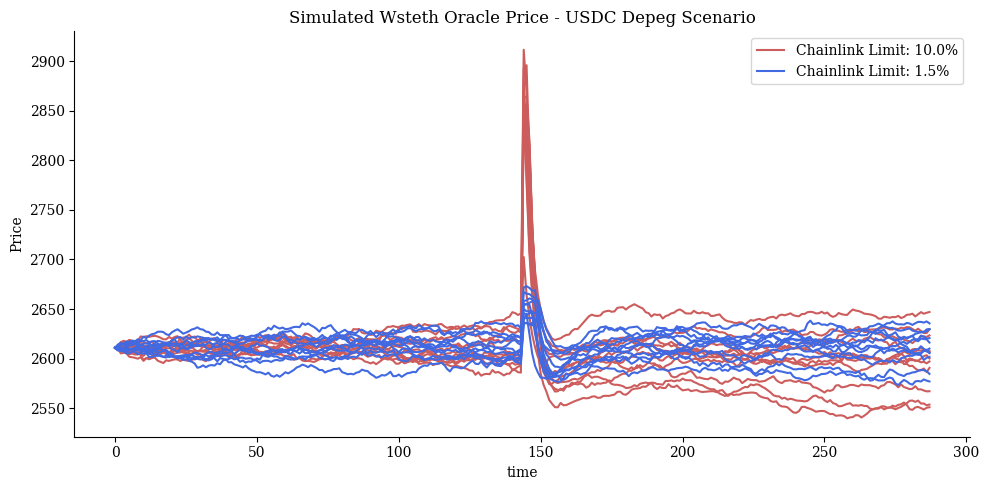

In [57]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

r = chainlink_results[2]
limit = r.metadata["params"]["chainlink_limit"] / 1e18 * 100
for datum in r.data[:10]:
    ax.plot(datum.df.reset_index()["Llamma Wsteth Oracle Price"], color="indianred")
ax.plot(
    r.data[25].df.reset_index()["Llamma Wsteth Oracle Price"],
    color="indianred",
    label=f"Chainlink Limit: {limit}%",
)

r = chainlink_results[0]
limit = r.metadata["params"]["chainlink_limit"] / 1e18 * 100
for datum in r.data[:10]:
    ax.plot(datum.df.reset_index()["Llamma Wsteth Oracle Price"], color="royalblue")
ax.plot(
    r.data[25].df.reset_index()["Llamma Wsteth Oracle Price"],
    color="royalblue",
    label=f"Chainlink Limit: {limit}%",
)

ax.legend()
ax.set_title("Simulated Wsteth Oracle Price - USDC Depeg Scenario")
ax.set_ylabel("Price")
ax.set_xlabel("time")
f.tight_layout()
f.savefig("../figs/results/chainlink_limits_oracle.png", dpi=300)
plt.show()